In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract

In [7]:
spark = SparkSession.builder \
    .appName("Web Log Analysis on Hadoop") \
    .master("yarn") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

print("Spark version:", spark.version)

# Read the log file from HDFS
log_path = "hdfs://localhost:9000/input/NASA_access_log_Jul95.gz"
# Read as text
logs_df = spark.read.text(log_path)
print("Total lines:", logs_df.count())
logs_df.show(5, truncate=False)


Spark version: 3.5.6


[Stage 5:>                                                          (0 + 1) / 1]

Total lines: 1891715
+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
+--

In [8]:
host_pattern = r'(^\S+)\s'
timestamp_pattern = r'\[(.*?)\]'
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
status_pattern = r'\s(\d{3})\s'
bytes_pattern = r'\s(\d+)$'

logs_df = logs_df.withColumn('host', regexp_extract('value', host_pattern, 1)) \
    .withColumn('timestamp', regexp_extract('value', timestamp_pattern, 1)) \
    .withColumn('method', regexp_extract('value', method_uri_protocol_pattern, 1)) \
    .withColumn('endpoint', regexp_extract('value', method_uri_protocol_pattern, 2)) \
    .withColumn('protocol', regexp_extract('value', method_uri_protocol_pattern, 3)) \
    .withColumn('status', regexp_extract('value', status_pattern, 1)) \
    .withColumn('content_size', regexp_extract('value', bytes_pattern, 1))

logs_df.select("host", "timestamp", "method", "endpoint", "status", "content_size").show(10, truncate=False)


+--------------------+--------------------------+------+-----------------------------------------------+------+------------+
|host                |timestamp                 |method|endpoint                                       |status|content_size|
+--------------------+--------------------------+------+-----------------------------------------------+------+------------+
|199.72.81.55        |01/Jul/1995:00:00:01 -0400|GET   |/history/apollo/                               |200   |6245        |
|unicomp6.unicomp.net|01/Jul/1995:00:00:06 -0400|GET   |/shuttle/countdown/                            |200   |3985        |
|199.120.110.21      |01/Jul/1995:00:00:09 -0400|GET   |/shuttle/missions/sts-73/mission-sts-73.html   |200   |4085        |
|burger.letters.com  |01/Jul/1995:00:00:11 -0400|GET   |/shuttle/countdown/liftoff.html                |304   |0           |
|199.120.110.21      |01/Jul/1995:00:00:11 -0400|GET   |/shuttle/missions/sts-73/sts-73-patch-small.gif|200   |4179        |


In [9]:
print("Total requests:", logs_df.count())

[Stage 10:>                                                         (0 + 1) / 1]

Total requests: 1891715


In [10]:
logs_df.groupBy("status").count().orderBy("status").show()
logs_df.groupBy("endpoint").count().orderBy("count", ascending=False).show(10, truncate=False)
logs_df.groupBy("host").count().orderBy("count", ascending=False).show(10, truncate=False)


+------+-------+
|status|  count|
+------+-------+
|      |      1|
|   200|1701536|
|   302|  46573|
|   304| 132627|
|   400|      5|
|   403|     54|
|   404|  10843|
|   500|     62|
|   501|     14|
+------+-------+



+----------------------------+------+
|endpoint                    |count |
+----------------------------+------+
|/images/NASA-logosmall.gif  |111330|
|/images/KSC-logosmall.gif   |89638 |
|/images/MOSAIC-logosmall.gif|60467 |
|/images/USA-logosmall.gif   |60013 |
|/images/WORLD-logosmall.gif |59488 |
|/images/ksclogo-medium.gif  |58801 |
|/images/launch-logo.gif     |40871 |
|/shuttle/countdown/         |40278 |
|/ksc.html                   |40226 |
|/images/ksclogosmall.gif    |33585 |
+----------------------------+------+
only showing top 10 rows



[Stage 19:>                                                         (0 + 1) / 1]

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|17572|
|piweba4y.prodigy.com|11591|
|piweba1y.prodigy.com|9868 |
|alyssa.prodigy.com  |7852 |
|siltb10.orl.mmc.com |7573 |
|piweba2y.prodigy.com|5922 |
|edams.ksc.nasa.gov  |5434 |
|163.206.89.4        |4906 |
|news.ti.com         |4863 |
|disarray.demon.co.uk|4353 |
+--------------------+-----+
only showing top 10 rows



In [11]:
from pyspark.sql.functions import avg, col

logs_df = logs_df.withColumn("content_size", col("content_size").cast("integer"))
logs_df.select(avg("content_size").alias("avg_size")).show()


[Stage 22:>                                                         (0 + 1) / 1]

+------------------+
|          avg_size|
+------------------+
|20671.058516934936|
+------------------+



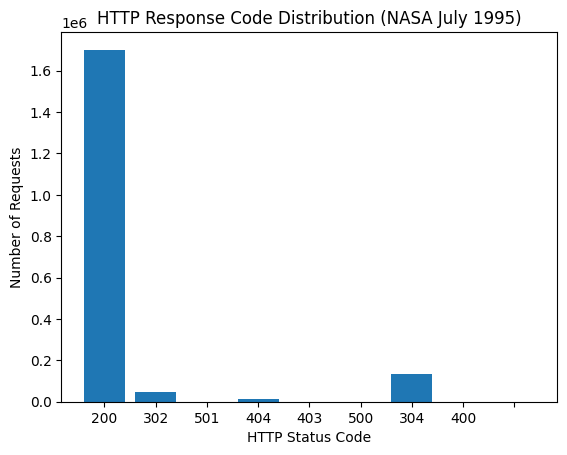

25/11/02 14:00:03 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 27263268 ms exceeds timeout 120000 ms
25/11/02 14:00:04 WARN SparkContext: Killing executors is not supported by current scheduler.
25/11/02 14:00:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint

In [12]:
import matplotlib.pyplot as plt

status_df = logs_df.groupBy("status").count().toPandas()

plt.bar(status_df["status"], status_df["count"])
plt.xlabel("HTTP Status Code")
plt.ylabel("Number of Requests")
plt.title("HTTP Response Code Distribution (NASA July 1995)")
plt.show()
